In [1]:
import pandas
import numpy.random
import vtreat
import sklearn.linear_model
import sklearn.metrics
import seaborn
import matplotlib.pyplot
import statsmodels.api
import scipy.stats
import re


In [2]:
n_rows = 5000
n_signal_variables = 10
n_noise_variables = 100
n_levels = 500

In [3]:
d = pandas.DataFrame({"y":0.01*numpy.random.normal(size = n_rows)})

In [4]:
def mk_var_values(n_levels):
    values = {}
    for i in range(n_levels):
        values["level_" + str(i)] = numpy.random.uniform(low=-10, high=10, size=1)[0]
    return values

In [5]:
for i in range(n_signal_variables):
    var_name = "var_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    effect = numpy.asarray([ levs[k] for k in observed ])
    d[var_name] = observed
    d["y"] = d["y"] + effect

In [6]:
for i in range(n_noise_variables):
    var_name = "noise_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    d[var_name] = observed

In [7]:
d.head()

,y,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,noise_90,noise_91,noise_92,noise_93,noise_94,noise_95,noise_96,noise_97,noise_98,noise_99
0,22.775176,level_311,level_121,level_7,level_483,level_69,level_278,level_365,level_9,level_226,...,level_35,level_385,level_375,level_192,level_196,level_442,level_156,level_36,level_492,level_78
1,24.352982,level_23,level_304,level_332,level_253,level_282,level_446,level_197,level_406,level_216,...,level_177,level_64,level_499,level_359,level_158,level_153,level_7,level_386,level_230,level_289
2,-13.566489,level_109,level_319,level_87,level_398,level_304,level_414,level_293,level_367,level_280,...,level_179,level_196,level_353,level_27,level_417,level_454,level_203,level_249,level_398,level_129
3,6.265087,level_342,level_466,level_318,level_155,level_20,level_10,level_467,level_117,level_429,...,level_113,level_315,level_475,level_441,level_454,level_268,level_415,level_281,level_52,level_312
4,-13.515709,level_404,level_21,level_213,level_40,level_416,level_336,level_412,level_345,level_269,...,level_392,level_155,level_486,level_457,level_217,level_246,level_324,level_416,level_254,level_497


In [8]:
is_train = numpy.random.uniform(size=n_rows)<=0.5

In [9]:
d_train = d.loc[is_train,:].copy()
d_train.reset_index(inplace=True, drop=True)
y_train = numpy.asarray(d_train["y"])
d_train.drop(["y"], axis=1, inplace=True)
d_test = d.loc[numpy.logical_not(is_train),:].copy()
d_test.reset_index(inplace=True, drop=True)
y_test = numpy.asarray(d_test["y"])
d_test.drop(["y"], axis=1, inplace=True)

In [10]:
plan = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                       'coders':['impact_code']}))
cross_frame = plan.fit_transform(d_train, y_train)
prepared_test = plan.transform(d_test)
naive_train_hierarchical = plan.transform(d_train)

In [11]:
p2 = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                     'coders':['impact_code'],
                                                                     'use_hierarchical_estimate':False}))
p2.fit_transform(d_train, y_train)
naive_train_empirical = p2.transform(d_train)

In [12]:
naive_train_empirical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,15.061879,-1.540986,-0.890991,9.670666,-3.454993,9.250591,10.639074,3.151160,-2.640028,10.379490,...,4.471915,-5.671643,1.503424,-6.803909,21.053631,10.693337,9.543931,6.818081,-0.026227,-0.621360
1,-11.892712,-21.539953,-8.773216,-9.318216,-7.842913,-18.508726,-11.215771,-9.089608,-3.940596,-11.573463,...,-3.732092,-8.244889,-3.542082,-22.034398,-27.328280,-17.127956,-0.051117,-14.887788,-21.324930,-4.295728
2,0.521529,-7.233678,-0.477355,-4.108175,-1.886170,11.889960,-9.415122,6.195813,12.081075,-10.885827,...,-4.166706,12.774035,-0.195442,-5.256442,-1.351710,-4.578687,2.931243,4.143390,-0.557308,-2.457902
3,-7.295014,5.236369,-21.612203,-3.304234,3.784895,-9.230998,-14.129825,-12.591619,-5.790395,-6.734660,...,-3.433975,-9.604537,-14.133148,3.201728,-11.271786,-3.258983,-18.179711,-8.580602,4.855174,-0.838015
4,-4.088363,3.328420,-7.407113,-9.541000,-4.032408,-11.700160,-13.117356,-9.970114,-26.597471,5.569067,...,4.248182,-0.189121,-9.401750,-22.034398,-4.488097,-0.559040,4.989311,-14.423241,-23.052195,-3.182365


In [13]:
naive_train_hierarchical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,7.801714,-1.085770,-0.522835,5.206321,-2.151423,6.765869,5.024599,1.938699,-1.647141,8.203962,...,2.945819,-2.137267,0.997403,-3.949815,20.370398,4.577283,8.496431,4.022974,-0.012004,-0.234064
1,-7.988588,-18.553292,-6.150580,-4.879697,-3.875362,-5.225092,-8.065012,-6.348183,-1.091794,-7.815721,...,-2.016141,-4.800464,-0.883094,-13.714303,-2.418531,-7.296593,-0.008875,-6.236051,-4.892873,-1.204500
2,0.378324,-5.339660,-0.227174,-2.854277,-0.891644,8.694430,-5.688687,3.429303,7.488761,-10.140173,...,-1.623172,5.526603,-0.126131,-4.731403,-1.054240,-3.542128,1.267691,3.104166,-0.351203,-1.753568
3,-4.982355,2.463251,-18.457004,-2.362337,1.303184,-7.455431,-9.553678,-8.401246,-4.523132,-3.903662,...,-0.263391,-6.393786,-8.489766,1.836502,-4.055804,-2.244911,-6.716252,-5.445452,2.879234,-0.494566
4,-2.431418,2.443760,-3.854322,-6.544108,-0.998679,-8.345780,-9.760007,-7.914820,-15.381267,4.084137,...,2.966677,-0.098888,-4.186111,-13.714303,-3.323976,-0.400936,1.377191,-5.960570,-15.143967,-2.231277


In [14]:
cross_frame.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,1.110223e-16,-3.589261,-8.219247,2.962872,-5.223563,-1.429906e+00,3.251693,-1.047220,-5.531903,7.288579,...,0.997993,-1.548539,2.027824,-7.295592,0.000000,0.362173,6.603430,3.801767,-3.211290e+00,-0.627059
1,-4.591422e+00,-17.221478,-7.644394,-5.346459,2.410111,-1.110223e-16,-5.824114,-4.903588,1.589400,-15.132191,...,1.308109,-9.009968,1.756426,-11.612415,-0.708438,-4.414400,7.309656,0.001944,-1.110223e-16,0.739534
2,3.702644e+00,-3.412760,0.151359,-1.948950,-0.166176,1.640434e+01,-0.662682,4.068451,6.487086,-12.715465,...,-1.300332,4.136824,0.361597,-3.261617,-0.882213,-3.353054,1.578962,4.580864,-2.078747e+00,0.000000
3,-3.320659e+00,7.235352,-13.434574,1.242888,7.150360,-4.774532e+00,-7.307612,-5.564283,-3.645527,-2.023520,...,0.000000,-0.205569,-6.129033,2.903676,-0.944282,1.335140,0.000000,-3.550838,1.067691e+01,2.045937
4,-1.676942e+00,7.380027,-0.739633,-3.331693,3.606529,-3.325244e+00,-7.730586,-4.647096,-6.878907,5.807267,...,7.104238,6.717565,-1.978131,-8.710291,-1.456776,-3.360140,3.192399,0.000000,-1.395977e+01,2.931920


In [15]:
all_vars = [vi for vi in plan.score_frame_["variable"]]
corr_frame = pandas.DataFrame({"variable":[vi for vi in all_vars if re.match(".*_impact_.*", vi)]})
corr_frame["naive_train_empirical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_empirical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["naive_train_hierarchical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_hierarchical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["cross_frame_correlation"] = [ 
    scipy.stats.pearsonr(cross_frame[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["test_correlation"] = [ 
    scipy.stats.pearsonr(prepared_test[vi], y_test)[0] for vi in corr_frame["variable"]]
corr_frame["is_noise"] = [re.match("^noise_.*", vi) is not None for vi in corr_frame["variable"]]
corr_frame


,variable,naive_train_empirical_correlation,naive_train_hierarchical_correlation,cross_frame_correlation,test_correlation,is_noise
0,var_0_impact_code,0.530863,0.510106,0.174630,0.143194,False
1,var_1_impact_code,0.513945,0.487530,0.109262,0.136384,False
2,var_2_impact_code,0.525874,0.497066,0.156747,0.181783,False
3,var_3_impact_code,0.561828,0.535025,0.209481,0.176500,False
4,var_4_impact_code,0.508162,0.482038,0.128741,0.160189,False
5,var_5_impact_code,0.525426,0.496256,0.141958,0.138994,False
6,var_6_impact_code,0.506118,0.478438,0.134688,0.160224,False
7,var_7_impact_code,0.529240,0.501518,0.151824,0.168292,False
8,var_8_impact_code,0.524287,0.502854,0.150045,0.180936,False
9,var_9_impact_code,0.542326,0.512277,0.151128,0.191143,False


(0.8425166057684847, 8.70840243326481e-31)


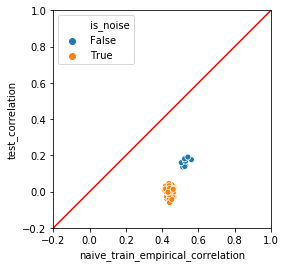

In [16]:
print(scipy.stats.pearsonr(corr_frame['naive_train_empirical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_empirical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.8387633073842826, 2.7949838836611957e-30)


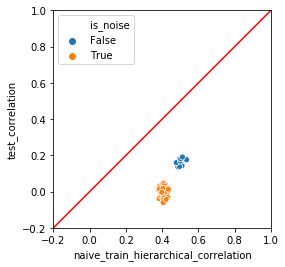

In [17]:
print(scipy.stats.pearsonr(corr_frame['naive_train_hierarchical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_hierarchical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.804325818129249, 3.634797795411103e-26)


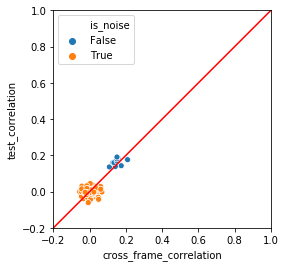

In [18]:
print(scipy.stats.pearsonr(corr_frame['cross_frame_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "cross_frame_correlation", y = "test_correlation", data = corr_frame,  hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

In [19]:
plan.score_frame_.tail()

,variable,treatment,y_aware,has_range,PearsonR,significance,vcount,recommended
105,noise_95_impact_code,impact_code,True,True,0.023645,0.233651,110.0,False
106,noise_96_impact_code,impact_code,True,True,-0.014600,0.462119,110.0,False
107,noise_97_impact_code,impact_code,True,True,-0.014702,0.459017,110.0,False
108,noise_98_impact_code,impact_code,True,True,-0.024380,0.219437,110.0,False
109,noise_99_impact_code,impact_code,True,True,0.061438,0.001954,110.0,True


In [20]:
recommended_vars = [vi for vi in plan.score_frame_["variable"][plan.score_frame_["recommended"]]]
recommended_vars

['var_0_impact_code',
 'var_1_impact_code',
 'var_2_impact_code',
 'var_3_impact_code',
 'var_4_impact_code',
 'var_5_impact_code',
 'var_6_impact_code',
 'var_7_impact_code',
 'var_8_impact_code',
 'var_9_impact_code',
 'noise_14_impact_code',
 'noise_24_impact_code',
 'noise_47_impact_code',
 'noise_99_impact_code']

In [21]:
plot_train = pandas.DataFrame({"y":y_train})
plot_test = pandas.DataFrame({"y":y_test})

In [22]:
fitter = sklearn.linear_model.LinearRegression(fit_intercept = True)

In [23]:
fitter.fit(cross_frame[all_vars], y_train)
plot_train["predict_cross_all_vars"] = fitter.predict(cross_frame[all_vars])
plot_test["predict_cross_all_vars"] = fitter.predict(prepared_test[all_vars])

In [24]:
fitter.fit(cross_frame[recommended_vars], y_train)
plot_train["predict_cross_recommended_vars"] = fitter.predict(cross_frame[recommended_vars])
plot_test["predict_cross_recommended_vars"] = fitter.predict(prepared_test[recommended_vars])

In [25]:
fitter.fit(naive_train_empirical[all_vars], y_train)
plot_train["predict_naive_empirical_all_vars"] = fitter.predict(naive_train_empirical[all_vars])
plot_test["predict_naive_empirical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [26]:
fitter.fit(naive_train_hierarchical[all_vars], y_train)
plot_train["predict_naive_hierarchical_all_vars"] = fitter.predict(naive_train_hierarchical[all_vars])
plot_test["predict_naive_hierarchical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [27]:
plot_test.head()

,y,predict_cross_all_vars,predict_cross_recommended_vars,predict_naive_empirical_all_vars,predict_naive_hierarchical_all_vars
0,24.352982,9.284178,5.212979,3.884805,6.415323
1,-13.566489,-4.499060,-4.164080,4.110997,6.042308
2,6.265087,18.469811,10.761815,4.840866,8.267574
3,-13.515709,-3.294186,2.113530,1.530464,1.941016
4,2.654435,2.724577,5.206861,-0.150335,0.234102


In [28]:
def rmse(x, y):
    return numpy.sqrt(numpy.mean((x-y)**2))

3.302822556560254


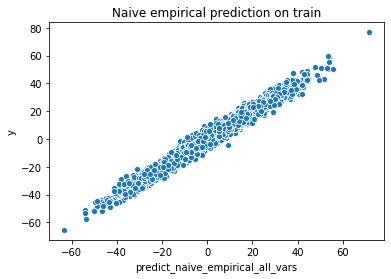

In [29]:
print(rmse(plot_train["predict_naive_empirical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive empirical prediction on train")

4.856084034149152


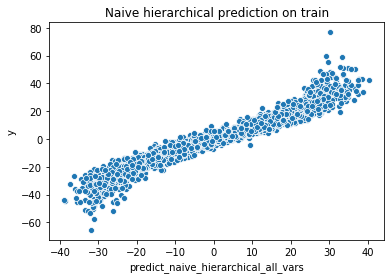

In [30]:
print(rmse(plot_train["predict_naive_hierarchical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on train")

15.670333517715957


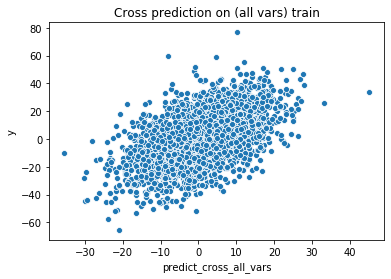

In [31]:
print(rmse(plot_train["predict_cross_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) train")

16.020602775563898


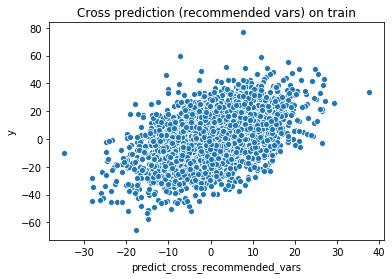

In [32]:
print(rmse(plot_train["predict_cross_recommended_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on train")

17.264860003073093


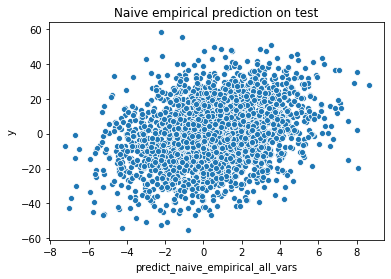

In [33]:
print(rmse(plot_test["predict_naive_empirical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive empirical prediction on test")

16.8756738779887


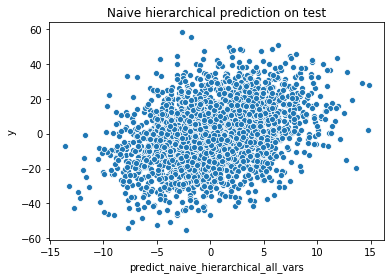

In [34]:
print(rmse(plot_test["predict_naive_hierarchical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on test")

15.518659857117965


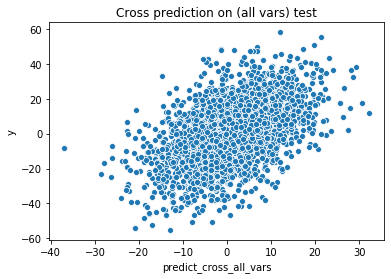

In [35]:
print(rmse(plot_test["predict_cross_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) test")

15.244912334439348


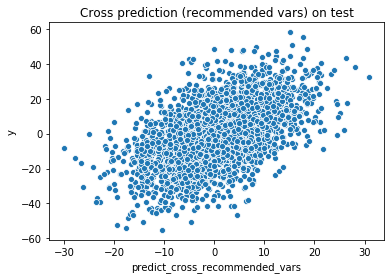

In [36]:
print(rmse(plot_test["predict_cross_recommended_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on test")

In [37]:
smf1 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(naive_train_empirical[all_vars])).fit()
smf1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     666.7
Date:                Fri, 26 Jul 2019   Prob (F-statistic):               0.00
Time:                        07:17:16   Log-Likelihood:                -6636.2
No. Observations:                2539   AIC:                         1.349e+04
Df Residuals:                    2428   BIC:                         1.414e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5269      0.067      7.861      0.000       0.395       0.658
var_0_impact_code        0.0669      0.008      8.194      0.000       0.051       0.083
var_1_impact_code        0.0618      0.008      7.405      0.000       0.045       0.078
var_2_impact_code        0.0618      0.008      7.489      0.000       0.046       0.078
var_3_impact_code        0.0631      0.008      7.886      0.000       0.047       0.079
var_4_impact_code        0.0652      0.008      7.753      0.000       0.049       0.082
var_5_impact_code        0.0795      0.008      9.665      0.000       0.063       0.096
var_6_impact_code        0.0714      0.008      8.424      0.000       0.055       0.088
var_7_impact_code        0.0491      0.008      5.901      0.000       0.033       0.065
var_8_impact_code        0.0661      0.008      7.979      0.000       0.050       0.082
var_9_impact_code        0.0728      0.008      9.051      0.000       0.057       0.089
noise_0_impact_code      0.0423      0.009      4.531      0.000       0.024       0.061
noise_1_impact_code      0.0498      0.009      5.336      0.000       0.031       0.068
noise_2_impact_code      0.0422      0.009      4.494      0.000       0.024       0.061
noise_3_impact_code      0.0488      0.009      5.226      0.000       0.031       0.067
noise_4_impact_code      0.0340      0.009      3.723      0.000       0.016       0.052
noise_5_impact_code      0.0386      0.009      4.239      0.000       0.021       0.056
noise_6_impact_code      0.0552      0.009      6.034      0.000       0.037       0.073
noise_7_impact_code      0.0413      0.009      4.552      0.000       0.023       0.059
noise_8_impact_code      0.0409      0.009      4.381      0.000       0.023       0.059
noise_9_impact_code      0.0484      0.009      5.211      0.000       0.030       0.067
noise_10_impact_code     0.0418      0.009      4.457      0.000       0.023       0.060
noise_11_impact_code     0.0359      0.009      3.960      0.000       0.018       0.054
noise_12_impact_code     0.0582      0.009      6.235      0.000       0.040       0.076
noise_13_impact_code     0.0500      0.009      5.536      0.000       0.032       0.068
noise_14_impact_code     0.0495      0.009      5.568      0.000       0.032       0.067
noise_15_impact_code     0.0468      0.009      5.095      0.000       0.029       0.065
noise_16_impact_code     0.0337      0.010      3.540      0.000       0.015       0.052
noise_17_impact_code     0.0402      0.009      4.258      0.000       0.022       0.059
noise_18_impact_code     0.0419      0.009      4.424      0.000       0.023       0.061
noise_19_impact_code     0.0371      0.009      4.085      0.000       0.019       0.055
noise_20_impact_code     0.0512      0.009      5.701    

In [38]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_naive_empirical_all_vars"])

0.9679537248831707

In [39]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_naive_empirical_all_vars"])

0.06662211065351364

In [40]:
smf2 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[all_vars])).fit()
smf2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     8.525
Date:                Fri, 26 Jul 2019   Prob (F-statistic):          4.00e-107
Time:                        07:17:16   Log-Likelihood:                -10589.
No. Observations:                2539   AIC:                         2.140e+04
Df Residuals:                    2428   BIC:                         2.205e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.5103      0.324      1.575      0.115      -0.125       1.146
var_0_impact_code        0.4308      0.049      8.821      0.000       0.335       0.527
var_1_impact_code        0.3151      0.048      6.558      0.000       0.221       0.409
var_2_impact_code        0.4356      0.048      9.159      0.000       0.342       0.529
var_3_impact_code        0.4753      0.043     11.118      0.000       0.392       0.559
var_4_impact_code        0.3739      0.049      7.560      0.000       0.277       0.471
var_5_impact_code        0.3807      0.048      7.909      0.000       0.286       0.475
var_6_impact_code        0.3920      0.050      7.883      0.000       0.295       0.490
var_7_impact_code        0.4130      0.049      8.496      0.000       0.318       0.508
var_8_impact_code        0.3995      0.049      8.164      0.000       0.304       0.495
var_9_impact_code        0.4081      0.045      9.008      0.000       0.319       0.497
noise_0_impact_code      0.1115      0.059      1.890      0.059      -0.004       0.227
noise_1_impact_code      0.0052      0.058      0.089      0.929      -0.109       0.119
noise_2_impact_code     -0.0563      0.055     -1.016      0.310      -0.165       0.052
noise_3_impact_code     -0.0116      0.061     -0.189      0.850      -0.132       0.109
noise_4_impact_code      0.1003      0.057      1.751      0.080      -0.012       0.213
noise_5_impact_code     -0.0418      0.055     -0.758      0.448      -0.150       0.066
noise_6_impact_code      0.0929      0.056      1.654      0.098      -0.017       0.203
noise_7_impact_code      0.0885      0.056      1.581      0.114      -0.021       0.198
noise_8_impact_code      0.0433      0.059      0.737      0.461      -0.072       0.159
noise_9_impact_code      0.0518      0.060      0.862      0.389      -0.066       0.170
noise_10_impact_code    -0.0608      0.060     -1.020      0.308      -0.178       0.056
noise_11_impact_code     0.0735      0.056      1.311      0.190      -0.036       0.183
noise_12_impact_code     0.0341      0.057      0.596      0.551      -0.078       0.146
noise_13_impact_code     0.1162      0.057      2.053      0.040       0.005       0.227
noise_14_impact_code     0.1194      0.056      2.116      0.034       0.009       0.230
noise_15_impact_code     0.0902      0.057      1.582      0.114      -0.022       0.202
noise_16_impact_code     0.0285      0.059      0.480      0.631      -0.088       0.145
noise_17_impact_code    -0.0776      0.060     -1.301      0.193      -0.195       0.039
noise_18_impact_code     0.0162      0.059      0.273      0.785      -0.100       0.132
noise_19_impact_code     0.0873      0.059      1.491      0.136      -0.027       0.202
noise_20_impact_code     0.0901      0.057      1.587    

In [41]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_all_vars"])

0.2786209051720834

In [42]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_all_vars"])

0.24588111802818324

In [43]:
smf3 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[recommended_vars])).fit()
smf3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     58.82
Date:                Fri, 26 Jul 2019   Prob (F-statistic):          2.20e-143
Time:                        07:17:16   Log-Likelihood:                -10646.
No. Observations:                2539   AIC:                         2.132e+04
Df Residuals:                    2524   BIC:                         2.141e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.4350      0.319      1.363      0.173      -0.191       1.061
var_0_impact_code        0.4378      0.048      9.128      0.000       0.344       0.532
var_1_impact_code        0.3246      0.047      6.840      0.000       0.232       0.418
var_2_impact_code        0.4365      0.047      9.343      0.000       0.345       0.528
var_3_impact_code        0.4953      0.042     11.844      0.000       0.413       0.577
var_4_impact_code        0.3772      0.049      7.757      0.000       0.282       0.473
var_5_impact_code        0.4042      0.047      8.515      0.000       0.311       0.497
var_6_impact_code        0.3857      0.049      7.873      0.000       0.290       0.482
var_7_impact_code        0.4100      0.048      8.583      0.000       0.316       0.504
var_8_impact_code        0.4108      0.048      8.537      0.000       0.316       0.505
var_9_impact_code        0.4070      0.045      9.143      0.000       0.320       0.494
noise_14_impact_code     0.1348      0.056      2.418      0.016       0.025       0.244
noise_24_impact_code     0.1509      0.054      2.775      0.006       0.044       0.258
noise_47_impact_code     0.1915      0.054      3.525      0.000       0.085       0.298
noise_99_impact_code     0.1290      0.055      2.340      0.019       0.021       0.237
==============================================================================
Omnibus:                        1.461   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.482   Jarque-Bera (JB):                1.444
Skew:                           0.058   Prob(JB):                        0.486
Kurtosis:                       3.003   Cond. No.                         7.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_recommended_vars"])

0.2460114032467815

In [45]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_recommended_vars"])

0.2722516170027486